In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

from SSN_classes import SSN_mid_local
from training import new_two_stage_training


jax backend cpu


In [2]:
from parameters import grid_pars, filter_pars, stimuli_pars, sig_pars, ssn_pars, conn_pars_m, conn_pars_s, ssn_layer_pars, conv_pars, training_pars, loss_pars
# Calculate A by using the default find_A function of SSN_mid_local when A is undefined
ssn_mid = SSN_mid_local(
    ssn_pars=ssn_pars, # got c_E and c_I as new parameters
    grid_pars=grid_pars,
    conn_pars=conn_pars_m,
    filter_pars=filter_pars,
    J_2x2 = ssn_layer_pars.J_2x2_m,
    gE = ssn_layer_pars.gE_m, 
    gI = ssn_layer_pars.gE_s
)

ssn_pars.A = ssn_mid.A
if ssn_pars.phases == 4:
    ssn_pars.A2 = ssn_mid.A2

####################### TRAINING PARAMETERS #############################
constant_ssn_pars = dict(
    ssn_pars=ssn_pars,
    grid_pars=grid_pars,
    conn_pars_m=conn_pars_m,
    conn_pars_s=conn_pars_s,
    gE=ssn_layer_pars.gE,
    gI=ssn_layer_pars.gI,
    filter_pars=filter_pars,
    conv_pars=conv_pars,# this got a lot of new stuff in it that might be a problem
    loss_pars=loss_pars,
    noise_type="poisson",
)
########### TRAINING ############
([ssn_layer_pars_dict, readout_pars],
    val_loss_per_epoch,
    training_losses,
    training_accs,
    train_sig_inputs,
    train_sig_outputs,
    val_sig_inputs,
    val_sig_outputs,
    epoch_c,
    save_w_sigs) = new_two_stage_training(
    ssn_layer_pars,
    sig_pars,
    training_pars,
    constant_ssn_pars,
    stimuli_pars,
    extra_stop=2,
    ssn_ori_map=ssn_mid.ori_map
    )

Loading orientation map
#### NOT SAVING! ####
Training loss: 4.592606067657471 ¦ Validation -- loss: 4.752053260803223, true accuracy: 0.5199999809265137, at epoch 0, (time 29.33866262435913, 0.8253214359283447), 
Training accuracy: 0.5600000023841858, all losses[[1.8163034 ]
 [0.40785038]
 [0.57385534]
 [1.794597  ]
 [0.        ]
 [4.592606  ]]
Training loss: 5.200352668762207 ¦ Validation -- loss: 4.8586225509643555, true accuracy: 0.46000000834465027, at epoch 1, (time 27.97824740409851, 0.8585772514343262), 
Training loss: 2.898557662963867 ¦ Validation -- loss: 3.1364803314208984, true accuracy: 0.6100000143051147, at epoch 20, (time 2.7406883239746094, 0.833280086517334), 
Entering second stage at epoch 20
Training loss: 2.664638042449951 ¦ Validation -- loss: 2.89943790435791, true accuracy: 0.6600000262260437, at epoch 1, (time 2.7406883239746094, 2.9579193592071533)
Training accuracy: 0.7099999785423279, all losses[[1.1163095e+00]
 [4.0583763e-01]
 [5.7432824e-01]
 [5.6810367e

In [3]:
from training_supp import sep_exponentiate
print(sep_exponentiate(ssn_layer_pars_dict['logJ_2x2'][0]))
print(ssn_layer_pars.J_2x2_m)
print(sep_exponentiate(ssn_layer_pars_dict['logJ_2x2'][1]))
print(ssn_layer_pars.J_2x2_s)

[[ 1.8061436 -1.0813522]
 [ 3.8995733 -1.5859859]]
[[ 1.935     -1.0062   ]
 [ 3.6377997 -1.7028   ]]
[[ 4.1936073 -1.811531 ]
 [ 5.354159  -1.2934192]]
[[ 4.4413204 -1.6582118]
 [ 5.0289063 -1.2416493]]


(100000,)
(100000,)


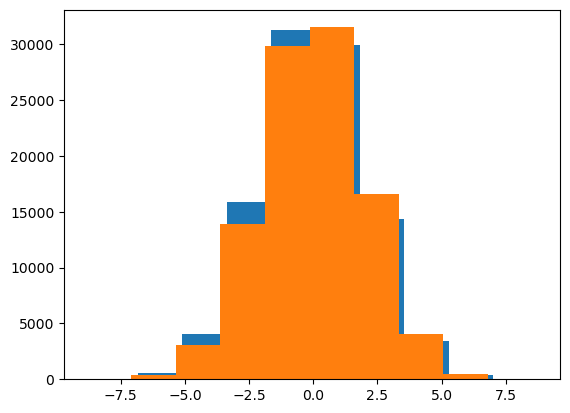

In [9]:
import numpy
import training_supp
def generate_noise2(sig_noise,  batch_size, length):
    '''
    Creates vectors of neural noise. Function creates N vectors, where N = batch_size, each vector of length = length. 
    '''
    return sig_noise*numpy.random.randn(batch_size, length)

noise2 = generate_noise2(training_pars.sig_noise,  training_pars.batch_size, 10000)
constant_ssn_pars1 = training_supp.generate_noise(constant_ssn_pars, training_pars.sig_noise,  training_pars.batch_size, 10000)
noise1 = constant_ssn_pars["noise_ref"]

import matplotlib.pyplot as plt
plt.hist(noise2[0])
plt.hist(noise1[0])
plt.show()